In [2]:
%%time

from pysme.linelist.vald import ValdFile
from pysme.sme import SME_Structure
from astropy import convolution
from pysme.solve import solve
from pysme.abund import Abund
from pysme import sme as SME
from pysme import util

from pysme.synthesize import synthesize_spectrum
from astropy.constants import c
from pysme.util import vac2air

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import sys
import os

warnings.filterwarnings('ignore')

CPU times: user 1.82 s, sys: 395 ms, total: 2.22 s
Wall time: 12.4 s


In [3]:
os.chdir('/home/fgran/iSpec/')
import ispec
sys.path.append('/home/fgran/iSpec/')

In [4]:
#Move to the correct directory: Pristine-UVES
os.chdir('/store/teams/cosmos/fgran/data/Pristine-UVES/')

In [5]:
os.environ['NUMEXPR_MAX_THREADS'] = '80' #change this number using the correct number of cores/threads in jupyter.slurm

In [6]:
#Prepare catalogue ingestion

In [7]:
uves = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr.csv')

In [11]:
uves.head(2)

,source_id,ebv,g0,eg,bp0,ebp,rp0,erp,cahk0,ecahk,...,evmac_nlte_fit,sme_nlte_vrad1,sme_nlte_vrad2,sme_nlte_vrad3,c,ec_sme,ec_fit,is_limit_c,niter_c,carbon_correction_03
0,1166634514845213568,0.034659,11.670373,0.002767,12.097350,0.002867,11.063974,0.003820,13.051166,0.009495,...,0.091985,0.085946,0.066876,-0.149777,8.350304,0.158630,0.005421,False,13,0.45
1,1172165023972931072,0.026574,12.876005,0.002772,13.314315,0.003091,12.258079,0.003841,14.291629,0.016091,...,0.079677,0.068610,0.068886,-0.103765,8.342535,0.164282,0.007953,False,13,0.19


In [93]:
#Create continuum model for N measurements

In [100]:
wmin_blue_1 = 3350 #AA
wmax_blue_1 = 3380 #AA
wmin_blue_2 = 3855 #AA
wmax_blue_2 = 3885 #AA

In [103]:
cont_blue = pd.read_csv('continuum_model/continuum_regions_blue2.txt', sep='\t')

In [104]:
blue_spec = ispec.read_spectrum('norm_RV_corr/111.251N.001/blue2_ADP.2023-04-24T10:49:45.001.fits')
blue_spec = ispec.resample_spectrum(blue_spec, np.arange(wmin_blue_1/10., wmax_blue_2/10., 2.*(2.0 * 0.0014)), method='bessel')
blue_spec.waveobs = blue_spec.waveobs * 10.
blue_spec.flux = convolution.convolve(blue_spec.flux, gaussian_kernel)

In [113]:
cont_blue.values

array([[330.08801091, 330.09351238],
       [330.22007133, 330.225575  ],
       [330.30263589, 330.30814093],
       ...,
       [389.77025113, 389.77674731],
       [389.8157265 , 389.82222342],
       [389.86120716, 389.88070044]])

In [118]:
%%time
#Nitrogen continuum regions
cont_mask_blue2 = np.zeros_like(blue_spec.waveobs)

for mask_i, wl in enumerate(blue_spec.waveobs):
    for cont_low, cont_high in cont_blue.values*10.:
        if (wl <= cont_low) | (wl >= cont_high):
            continue
        else:
            cont_mask_blue2[mask_i] = 2
            break

CPU times: user 9.84 s, sys: 60.3 ms, total: 9.9 s
Wall time: 9.89 s


In [140]:
np.savetxt('continuum_model/sme_cont_mask_blue2_lowres', np.column_stack((blue_spec.waveobs, cont_mask_blue2)), fmt=['%f', '%d'])

In [12]:
#pysme that only need to be executed once
# linelist_short_all = ValdFile('linelist/3800-6800_short.lin')
linelist = ValdFile('linelist/VALD_korg_linelist_3000_9000.lin', medium='air')
linelist.wlcent = vac2air(linelist.wlcent, 'A')
print('Number of lines in the linelist: %d' %linelist.species.size)

delta_H_line = 10. #AA
delta_line = 0.75 #AA
wl_G_band = 4300 #AA
delta_G_band = 40. #AA

wl_Halpha_line = 6562.79 #AA
delta_Halpha = 1.0 #AA
wl_Hbeta_line = 4861.35 #AA
delta_Hbeta = 0.75 #AA

[2025-01-27 11:26:03,691] [INFO] [vald:loads:174]: Loading VALD file linelist/VALD_korg_linelist_3000_9000.lin


INFO - Loading VALD file linelist/VALD_korg_linelist_3000_9000.lin
Number of lines in the linelist: 41861


In [13]:
# linelist = linelist[(linelist.wlcent > wmin_blue_1) & (linelist.wlcent < wmax_blue_1)]
#[(linelist.wlcent > wmin_blue_1) & (linelist.wlcent < wmax_blue_1) | (linelist.wlcent > wmin_blue_2) & (linelist.wlcent < wmax_blue_2)]

In [14]:
#Create solar scaled atmosphere with [alpha/Fe] = +0.4
solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

abund = solar.abund.pattern
abund['O'] = abund['O'] + 0.4
abund['Ne'] = abund['Ne'] + 0.4
abund['Mg'] = abund['Mg'] + 0.4
abund['Si'] = abund['Si'] + 0.4
abund['S'] = abund['S'] + 0.4
abund['Ar'] = abund['Ar'] + 0.4
abund['Ca'] = abund['Ca'] + 0.4
abund['Ti'] = abund['Ti'] + 0.4

In [15]:
np.unique(linelist.species)

array(['Ag 1', 'Al 1', 'Al 2', 'As 1', 'Au 1', 'Ba 1', 'Ba 2', 'Be 1',
       'Be 2', 'Bi 1', 'C 1', 'C2 1', 'CH 1', 'CN 1', 'Ca 1', 'Ca 2',
       'Cd 1', 'Ce 2', 'Co 1', 'Co 2', 'Cr 1', 'Cr 2', 'Cu 1', 'Dy 1',
       'Dy 2', 'Er 1', 'Er 2', 'Eu 2', 'Fe 1', 'Fe 2', 'Ga 1', 'Gd 1',
       'Gd 2', 'Ge 1', 'H 1', 'Hf 1', 'Hf 2', 'Hg 1', 'Ho 2', 'In 1',
       'Ir 1', 'Ir 2', 'K 1', 'La 2', 'Li 1', 'Lu 2', 'Mg 1', 'Mg 2',
       'Mn 1', 'Mn 2', 'Mo 1', 'Mo 2', 'N 1', 'NH 1', 'Na 1', 'Nb 1',
       'Nb 2', 'Nd 2', 'Nd 3', 'Ni 1', 'Ni 2', 'O 1', 'OH 1', 'Os 1',
       'Os 2', 'Pb 1', 'Pd 1', 'Pr 2', 'Pt 1', 'Rb 1', 'Re 1', 'Re 2',
       'Rh 1', 'Ru 1', 'Ru 2', 'S 1', 'Sb 1', 'Sc 1', 'Sc 2', 'Se 1',
       'Si 1', 'Si 2', 'Sm 2', 'Sn 1', 'Sr 1', 'Sr 2', 'Ta 2', 'Tb 2',
       'Te 1', 'Th 2', 'Ti 1', 'Ti 2', 'Tl 1', 'Tm 2', 'U 2', 'V 1',
       'V 2', 'W 1', 'W 2', 'Y 1', 'Y 2', 'Yb 1', 'Yb 2', 'Zn 1', 'Zr 1',
       'Zr 2'], dtype='<U4')

In [16]:
elems_to_include = ['NH 1', 'CN 1']

In [17]:
mask_cont_nh = pd.read_csv('continuum_model/sme_cont_mask_blue2_lowres', delim_whitespace=True, names=['wl', 'mask_values'])
mask_cont_cn = pd.read_csv('continuum_model/sme_cont_mask_blue2', delim_whitespace=True, names=['wl', 'mask_values'])

In [18]:
gaussian_kernel = convolution.Gaussian1DKernel(stddev=42000/21000)

In [19]:
#Main loop for stars NH
def sme_parallel_nh(i, input_row, tol=1e-5):

    #Create SME structures
    sme = SME_Structure()

    sme.ipres = 42000/2 # 42000
    sme.iptype = 'gauss'
    sme.gam6 = True
    sme.h2broad = True

    sme.atmo.source = 'marcs2012s_t2.0.sav'
    sme.atmo.method = 'grid'
    sme.atmo.geom = 'SPH'

    sme.accxt = tol
    sme.accgt = tol
    sme.accft = tol
    sme.leastsquare3_ftol = tol
    sme.leastsquares_gtol = tol
    sme.leastsquares_xtol = tol
    sme.vrad_bounds = -5., 5.

    sme.accwi  = tol
    sme.accrt  = tol
    sme.clim   = tol
    sme.chirat = tol

    sme.cscale_flag = 'constant'
    # sme.cscale = 1.0
    # sme.cscale_type = 'mask'
    sme.cscale_type = 'mcmc'
    sme.fitresults.maxiter = 100

    # Redirect output to logs/RUN*/*.txt
    util.start_logging(log_file='logs/nfe_run.txt', level='ERROR')

    #Reading norm specta from files
    blue_spec = ispec.read_spectrum('norm_RV_corr/%s/blue2_%s' %(input_row.run, input_row.blue_file))
    blue_spec = ispec.resample_spectrum(blue_spec, np.arange(wmin_blue_1/10., wmax_blue_2/10., 2.*(2.0 * 0.0014)), method='bessel')
    blue_spec.waveobs = blue_spec.waveobs * 10.
    blue_spec.flux = convolution.convolve(blue_spec.flux, gaussian_kernel)

    sme.wave = blue_spec.waveobs[(blue_spec.waveobs > wmin_blue_1) & (blue_spec.waveobs < wmax_blue_1)]
    sme.spec = blue_spec.flux[(blue_spec.waveobs > wmin_blue_1) & (blue_spec.waveobs < wmax_blue_1)]
    sme.uncs = blue_spec.err[(blue_spec.waveobs > wmin_blue_1) & (blue_spec.waveobs < wmax_blue_1)]

    del blue_spec

    #Masking process to derive Teff, logg, monh and vmic (vmac if needed)
    # The mask values are: 0: bad pixel, 1: line pixel, 2: continuum pixel
    line_regions = np.zeros_like(sme.wave.data).astype(int) # mask_cont.mask_values.values[(mask_cont.wl.values > wmin_blue_1) & (mask_cont.wl.values < wmax_blue_1)] # np.zeros_like(sme.wave.data).astype(int)
    # mask_cont.mask_values.values[((mask_cont.wl.values > wmin_blue_1) & (mask_cont.wl.values < wmax_blue_1)) | ((mask_cont.wl.values > wmin_blue_2) & (mask_cont.wl.values < wmax_blue_2))]
    # np.zeros_like(sme.wave.data).astype(int) #mask_cont #np.zeros_like(sme.wave.data).astype(int)
    linelist_nh = linelist[(linelist.wlcent > wmin_blue_1) & (linelist.wlcent < wmax_blue_1)]
    ll_mask = np.zeros(linelist_nh.species.size).astype(bool)

    for wline, mask_species in linelist_nh[['wlcent', 'species']]:
        if mask_species in elems_to_include:
            idx_ = (sme.wave.data > wline-delta_line) & (sme.wave.data < wline+delta_line)
            line_regions[idx_] = 1
            ll_mask[(linelist_nh.wlcent > wline-delta_line) & (linelist_nh.wlcent < wline+delta_line)] = True
            continue
    del idx_

    #Merge all the line_regions as int
    line_regions = line_regions.astype(int)
    line_regions[sme.spec.data == 0.0] = 0
    sme.mask = line_regions
    del line_regions

    sme.linelist = linelist_nh[ll_mask]
    del linelist_nh

    #Abundance scaling to create realistic synthetics
    sme.abund = abund
    #RV determination for each chip
    sme.vrad_flag = 'each'

    #input guesses from SME
    sme.teff = input_row.teff
    sme.logg = input_row.logg
    sme.monh = input_row.monh
    sme.vmic = input_row.vmic
    sme.vmac = input_row.vmac
    sme.vrad = input_row.sme_vrad1

    sme.abund.update_pattern({'Fe':input_row.fe})
    sme.abund.update_pattern({'N':solar.abund.get_element('N')})
    sme.abund.update_pattern({'C':input_row.c})

    fitparameters = ['abund N']
    #Do the heavy lifting
    sme = solve(sme, fitparameters)

    nfe, enfe_sme, enfe_fit, niter = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0], sme.fitresults.iterations

    sme.save('sme_save/UVES_nfe_nh_%s' %input_row.spec_id)
    # del sme

    columns = ['spec_id', 'nfe_nh', 'enfe_nh_sme', 'nfe_nh_fit', 'niter_n_nh']
    data_to_write = np.vstack((input_row.spec_id, nfe, enfe_sme, enfe_fit, niter)).T
    pd.DataFrame(data=data_to_write, columns=columns).to_csv('tmp_nitrogen/UVES_nfe_nh_%s.csv' %input_row.spec_id, index=False, header=False)
    del data_to_write

    return

In [20]:
#Main loop for stars CN
def sme_parallel_cn(i, input_row, tol=1e-5):

    #Create SME structures
    sme = SME_Structure()

    sme.ipres = 42000/2 # 42000
    sme.iptype = 'gauss'
    sme.gam6 = True
    sme.h2broad = True

    sme.atmo.source = 'marcs2012s_t2.0.sav'
    sme.atmo.method = 'grid'
    sme.atmo.geom = 'SPH'

    sme.accxt = tol
    sme.accgt = tol
    sme.accft = tol
    sme.leastsquare3_ftol = tol
    sme.leastsquares_gtol = tol
    sme.leastsquares_xtol = tol
    sme.vrad_bounds = -5., 5.

    sme.accwi  = tol
    sme.accrt  = tol
    sme.clim   = tol
    sme.chirat = tol

    sme.cscale_flag = 'constant'
    # sme.cscale = 1.0
    sme.cscale_type = 'mask'
    # sme.cscale_type = 'mcmc'
    sme.fitresults.maxiter = 100

    # Redirect output to logs/RUN*/*.txt
    util.start_logging(log_file='logs/nfe_run.txt', level='ERROR')

    #Reading norm specta from files
    blue_spec = ispec.read_spectrum('norm_RV_corr/%s/blue2_%s' %(input_row.run, input_row.blue_file))
    blue_spec.waveobs = blue_spec.waveobs * 10.
    sme.wave = blue_spec.waveobs[(blue_spec.waveobs > wmin_blue_2) & (blue_spec.waveobs < wmax_blue_2)]
    sme.spec = blue_spec.flux[(blue_spec.waveobs > wmin_blue_2) & (blue_spec.waveobs < wmax_blue_2)]
    sme.uncs = blue_spec.err[(blue_spec.waveobs > wmin_blue_2) & (blue_spec.waveobs < wmax_blue_2)]

    del blue_spec

    #Masking process to derive Teff, logg, monh and vmic (vmac if needed)
    # The mask values are: 0: bad pixel, 1: line pixel, 2: continuum pixel
    line_regions = mask_cont_cn.mask_values.values[(mask_cont_cn.wl.values > wmin_blue_2) & (mask_cont_cn.wl.values < wmax_blue_2)]
    linelist_cn = linelist[(linelist.wlcent > wmin_blue_2) & (linelist.wlcent < wmax_blue_2)]
    ll_mask = np.zeros(linelist_cn.species.size).astype(bool)

    for wline, mask_species in linelist_cn[['wlcent', 'species']]:
        if mask_species in elems_to_include:
            idx_ = (sme.wave.data > wline-delta_line) & (sme.wave.data < wline+delta_line)
            line_regions[idx_] = 1
            ll_mask[(linelist_cn.wlcent > wline-delta_line) & (linelist_cn.wlcent < wline+delta_line)] = True
            continue
    del idx_

    #Merge all the line_regions as int
    line_regions = line_regions.astype(int)
    line_regions[sme.spec.data == 0.0] = 0
    sme.mask = line_regions
    del line_regions

    sme.linelist = linelist_cn[ll_mask]
    del linelist_cn

    #Abundance scaling to create realistic synthetics
    sme.abund = abund
    #RV determination for each chip
    sme.vrad_flag = 'each'

    #input guesses from SME
    sme.teff = input_row.teff
    sme.logg = input_row.logg
    sme.monh = input_row.monh
    sme.vmic = input_row.vmic
    sme.vmac = input_row.vmac
    sme.vrad = input_row.sme_vrad1

    sme.abund.update_pattern({'Fe':input_row.fe})
    sme.abund.update_pattern({'N':solar.abund.get_element('N')})
    sme.abund.update_pattern({'C':input_row.c})

    fitparameters = ['abund N']
    #Do the heavy lifting
    sme = solve(sme, fitparameters)

    nfe, enfe_sme, enfe_fit, niter = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0], sme.fitresults.iterations

    sme.save('sme_save/UVES_nfe_cn_%s' %input_row.spec_id)
    # del sme

    columns = ['spec_id', 'nfe_cn', 'enfe_cn_sme', 'nfe_cn_fit', 'niter_n_cn']
    data_to_write = np.vstack((input_row.spec_id, nfe, enfe_sme, enfe_fit, niter)).T
    pd.DataFrame(data=data_to_write, columns=columns).to_csv('tmp_nitrogen/UVES_nfe_cn_%s.csv' %input_row.spec_id, index=False, header=False)
    del data_to_write

    return

In [258]:
%%time

#Single execution NH
Parallel(n_jobs=-1, verbose=1)(delayed(sme_parallel_nh)(i, input_row, tol=1e-7) for i, input_row in uves.iterrows())
# sme = sme_parallel)nh(0, uves.iloc[0], tol=1e-4)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[2025-01-26 11:20:15,840] [WARNING] [__init__:_rc_params_in_file:879]: Missing colon in file PosixPath('/misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8.mplstyle'), line 1 ('\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

CPU times: user 2 s, sys: 1.57 s, total: 3.57 s
Wall time: 49min 29s


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 49.5min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [259]:
%%time

#Single execution CN
Parallel(n_jobs=-1, verbose=1)(delayed(sme_parallel_cn)(i, input_row, tol=1e-7) for i, input_row in uves.iterrows())
# sme = sme_parallel_cn(0, uves.iloc[0], tol=1e-4)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[2025-01-26 12:09:30,878] [WARNING] [__init__:_rc_params_in_file:879]: Missing colon in file PosixPath('/misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8.mplstyle'), line 1 ('\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

CPU times: user 1.57 s, sys: 933 ms, total: 2.51 s
Wall time: 22min 23s


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 22.4min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [273]:
%%time

os.system('cat tmp_nitrogen/UVES_nfe_nh* > tmp_merged/UVES_nfe_nh.csv');
!sed -i '1i \spec_id,n_nh,en_nh_sme,en_nh_fit,niter_n_nh' tmp_merged/UVES_nfe_nh.csv

os.system('cat tmp_nitrogen/UVES_nfe_cn* > tmp_merged/UVES_nfe_cn.csv');
!sed -i '1i \spec_id,n_cn,en_cn_sme,en_cn_fit,niter_n_cn' tmp_merged/UVES_nfe_cn.csv

CPU times: user 11.4 ms, sys: 22.2 ms, total: 33.6 ms
Wall time: 1min 26s


In [6]:
#Check nitrogens

In [7]:
nfe_nh  = pd.read_csv('tmp_merged/UVES_nfe_nh.csv')
nfe_cn  = pd.read_csv('tmp_merged/UVES_nfe_cn.csv')
uves  = pd.read_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr.csv')
uves_nfe  = uves.merge(right=nfe_nh, right_on='spec_id', left_on='spec_id').merge(right=nfe_cn, right_on='spec_id', left_on='spec_id')

In [8]:
uves_nfe['is_limit_n_nh'] = True
uves_nfe['is_limit_n_nh'][uves_nfe.n_nh.values < 6.] = False
uves_nfe['is_limit_n_cn'] = True
uves_nfe['is_limit_n_cn'][uves_nfe.n_cn.values < 6.] = False

In [14]:
uves_nfe.to_csv('tmp_merged/UVES_p111_p112_pristinedr1_xgboost_logg_atm_uncs_fe_c_corr_n.csv', index=False, header=True)

In [41]:
#Plots

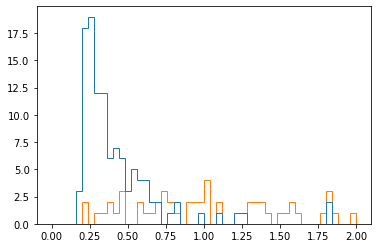

In [42]:
plt.hist([uves_nfe.en_nh_sme.values, uves_nfe.en_cn_sme.values], bins=50, histtype='step', range=(0, 2))
plt.show()

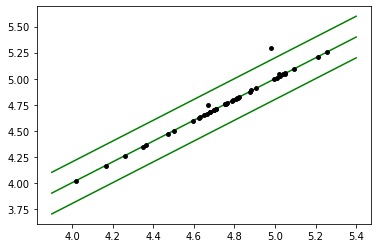

In [13]:
f_n_err = (uves_nfe.is_limit_n_nh.values == False) & (uves_nfe.is_limit_n_cn.values == False)
plt.scatter(uves_nfe.n_cn.values[f_n_err], uves_nfe.n_nh.values[f_n_err], s=15, color='k')
# plt.errorbar(uves_nfe.n_cn.values[f_n_err], uves_nfe.n_nh.values[f_n_err], fmt='.k', alpha=0.5, xerr=uves_nfe.en_cn_sme.values[f_n_err]/1e5, yerr=uves_nfe.en_nh_sme.values[f_n_err]/1e5)
# plt.xlim(3.5, 5.5)
# plt.ylim(3.5, 5.5)
x = np.linspace(3.9,5.4, 15)
plt.plot(x,x, color='g', zorder=0)
plt.plot(x,x+0.2, color='g', zorder=0)
plt.plot(x,x-0.2, color='g', zorder=0)
plt.show()

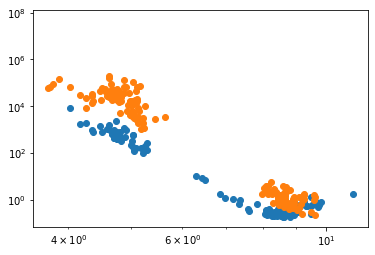

In [35]:
plt.scatter(uves_nfe.n_nh.values, uves_nfe.en_nh_sme.values)
plt.scatter(uves_nfe.n_cn.values, uves_nfe.en_cn_sme.values)
plt.loglog()
plt.show()

In [315]:
cfe = uves_nfe.c.values - solar.abund.get_element('C')
nfe = uves_nfe.n_nh.values - solar.abund.get_element('N')

In [316]:
uves_nfe.head(2)

,source_id,ebv,g0,eg,bp0,ebp,rp0,erp,cahk0,ecahk,...,niter_c,carbon_correction_03,n_nh,en_nh_sme,en_nh_fit,niter_n_nh,n_cn,en_cn_sme,en_cn_fit,niter_n_cn
0,1166634514845213568,0.034659,11.670373,0.002767,12.097350,0.002867,11.063974,0.003820,13.051166,0.009495,...,13,0.45,8.085670,0.333929,0.016327,18,5.052851,4300.554092,285.064617,1
1,1172165023972931072,0.026574,12.876005,0.002772,13.314315,0.003091,12.258079,0.003841,14.291629,0.016091,...,13,0.19,8.122671,0.281719,0.014353,15,4.691659,36267.501171,3576.525820,1


In [320]:
f_nfe_err = (uves_nfe.en_nh_sme.values < 1.0) & (uves_nfe.ec_sme.values < 1.0)

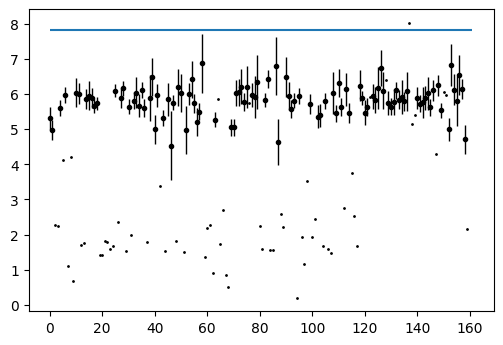

In [321]:
plt.figure(dpi=100)
plt.scatter(uves_nfe.index.values, uves_nfe.n_nh.values + uves_nfe.monh.values, s=1, color='k')
plt.errorbar(uves_nfe.index.values[f_nfe_err], uves_nfe.n_nh.values[f_nfe_err] + uves_nfe.monh.values[f_nfe_err], yerr=uves_nfe.en_nh_sme.values[f_nfe_err], fmt='k.', lw=1)

plt.hlines(solar.abund.get_element('N'), 0, 161)
# plt.ylim(4, 11)
plt.show()

In [74]:
# uves_nfe[f_nfe_err].sort_values(by='en', ascending=False).spec_id

In [37]:
#limits

In [70]:
def limits(species = 'N', species_to_keep = [], spec_id = '', sme_file = '', wlmin = 0, wlmax = 0, start = -2.0, stop = 2.0, step = 0.25):
    
    # plt.figure(figsize=(7,7), dpi=100)
    
    util.start_logging('logs/elems_limits.dat', level='WARNING')
    # species = 'C'
    limit = solar.abund.get_element('%s' %species)
    # start, stop, step = -2.0, 2.0, 0.25

    for delta_abund in np.linspace(start, stop, int((stop - start) / step + 1)):

        synth = SME_Structure.load(sme_file)
        # if delta_abund == start: print(synth.abund.get_element(species))
        # if delta_abund == start: plt.step(synth.wave.data, synth.synth.data, lw=1, color='r')
        synth.linelist = linelist_short_all[(linelist_short_all.wlcent > wlmin) & (linelist_short_all.wlcent < wlmax)]

        f_wl_limit = (synth.wave.data > wlmin) & (synth.wave.data < wlmax)

        for elem in synth.abund.pattern.keys():
            if (elem == 'H') or (elem == 'He'):
                continue
            if elem in species_to_keep:
                continue
            synth.abund.update_pattern({elem:0.0})
        synth.abund.update_pattern({'%s' %species: solar.abund.get_element('%s' %species) + delta_abund})
        # print('%s' %species, solar.abund.get_element('%s' %species) + delta_abund)

        synth.vrad_flag = 'None'
        synth.cscale_flag = 'None'
        synth = synthesize_spectrum(synth)
        # synth_data = synth.synth.data

        mean_synth = np.percentile(synth.synth.data[f_wl_limit], 10)
        std_spec = np.std(synth.spec.data[f_wl_limit])
        
        # if delta_abund == start: plt.step(synth.wave.data, synth.spec.data, lw=1, color='k')
        # if delta_abund == start: plt.hlines(1.-std_spec, wlmin, wlmax, color='b', lw=1, ls='--')
        # plt.step(synth.wave.data, synth.synth.data, lw=1, color='g', alpha=0.5)
        # plt.hlines(mean_synth, wlmin, wlmax, color='r', lw=1, ls='--', alpha=0.3)
        # plt.xlim(wlmin, wlmax)

        #If mean synth flux is more (bigger depth) that std: you are in outside limit regime
        #linspace in the starst is fliped to ascend in abundance space
        if mean_synth < (1. - std_spec):
            limit = solar.abund.get_element('%s' %species) + delta_abund - step/2.
            # plt.show()
            return limit
        else:
            continue
    # plt.show()
    return limit

In [71]:
nfe  = pd.read_csv('tmp_merged/nfe.csv')
uves  = pd.read_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon_limits.csv', index_col=0)
uves_nfe  = uves.merge(right=nfe, right_on='spec_id', left_on='spec_id')

In [72]:
uves_nfe.rename(columns={'en_sme':'en'}, inplace=True)

In [73]:
uves_nfe.head(2)

,source_id,ebv,g0,eg,bp0,ebp,rp0,erp,cahk0,ecahk,...,vmac,evmac,c,ec,ec_fit,is_limit_c,limit_c,n,en,en_fit
0,1166634514845213568,0.034659,11.670373,0.002767,12.097350,0.002867,11.063974,0.003820,13.051166,0.009495,...,5.115226,0.110029,8.464024,0.149136,0.004981,False,8.464024,8.850937,0.719770,0.037053
1,1172165023972931072,0.026574,12.876005,0.002772,13.314315,0.003091,12.258079,0.003841,14.291629,0.016091,...,4.785015,0.274269,8.414520,0.139613,0.005474,False,8.414520,8.607935,0.597183,0.041733


In [74]:
is_limit = np.zeros_like(uves_nfe.n.values).astype(bool)
abund_limit = uves_nfe.n.values

In [75]:
is_limit[(uves_nfe.en.values > 1.0) | (uves_nfe.n.values < 4.0)] = True

In [76]:
%%time

# wmin_blue_1 = 3350 #AA
# wmax_blue_1 = 3380 #AA
# wmin_blue_2 = 3855 #AA
# wmax_blue_2 = 3885 #AA

for i, limit in enumerate(is_limit):
    if limit:
        abund_limit[i] = limits('N', ['C'], uves_nfe.spec_id.values[i], 'sme_save/nfe_%s.sme' %uves_nfe.spec_id.values[i], wlmin=3881, wlmax=3884)

CPU times: user 59min 32s, sys: 3.49 s, total: 59min 36s
Wall time: 59min 56s


In [78]:
uves_nfe['is_limit_n'] = is_limit
uves_nfe['limit_n'] = abund_limit

In [79]:
uves_nfe.head(2)

,source_id,ebv,g0,eg,bp0,ebp,rp0,erp,cahk0,ecahk,...,c,ec,ec_fit,is_limit_c,limit_c,n,en,en_fit,is_limit_n,limit_n
0,1166634514845213568,0.034659,11.670373,0.002767,12.097350,0.002867,11.063974,0.003820,13.051166,0.009495,...,8.464024,0.149136,0.004981,False,8.464024,8.850937,0.719770,0.037053,False,8.850937
1,1172165023972931072,0.026574,12.876005,0.002772,13.314315,0.003091,12.258079,0.003841,14.291629,0.016091,...,8.414520,0.139613,0.005474,False,8.414520,8.607935,0.597183,0.041733,False,8.607935


In [80]:
uves_nfe.to_csv('uves_p111_p112_pristinedr1_xgboost_atm_means_carbon_nitrogen_limits.csv', index=False, header=True)

In [322]:
# jina = pd.read_csv('JINA/JINAbase_2021_nolims.csv')

solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

In [323]:
is_limit = (uves_nfe.en_nh_sme.values < 1.5) & (uves_nfe.ec_sme.values < 1.5)

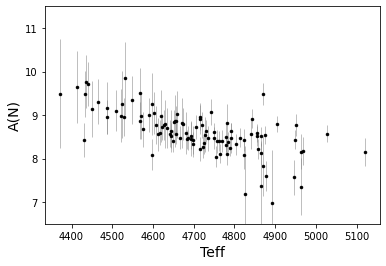

In [324]:
plt.scatter(uves_nfe.teff.values[is_limit], uves_nfe.n_nh.values[is_limit], s=5, color='k', zorder=9)
plt.errorbar(uves_nfe.teff.values[is_limit], uves_nfe.n_nh.values[is_limit], yerr=uves_nfe.en_nh_sme.values[is_limit], fmt='.', color='grey', alpha=0.5, lw=1)

# plt.errorbar(uves_nfe.teff.values[is_limit], uves_nfe.n.values[~is_limit], fmt='.', yerr=0.2 * np.ones_like(uves_nfe.en_sme.values[is_limit]), ms=0.1, uplims=is_limit[is_limit], color='k', alpha=0.2)

plt.xlabel('Teff', size=14)
plt.ylabel('A(N)', size=14)
plt.ylim(6.5, 11.5)
plt.show()

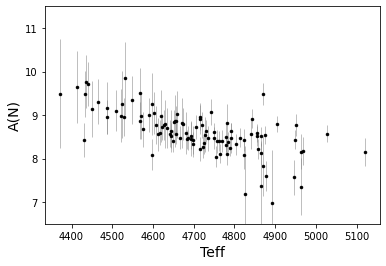

In [325]:
plt.scatter(uves_nfe.teff.values[is_limit], uves_nfe.n_nh.values[is_limit], s=5, color='k', zorder=9)
plt.errorbar(uves_nfe.teff.values[is_limit], uves_nfe.n_nh.values[is_limit], yerr=uves_nfe.en_nh_sme.values[is_limit], fmt='.', color='grey', alpha=0.5, lw=1)

# plt.errorbar(uves_nfe.teff.values[is_limit], uves_nfe.n.values[~is_limit], fmt='.', yerr=0.2 * np.ones_like(uves_nfe.en_sme.values[is_limit]), ms=0.1, uplims=is_limit[is_limit], color='k', alpha=0.2)

plt.xlabel('Teff', size=14)
plt.ylabel('A(N)', size=14)
plt.ylim(6.5, 11.5)
plt.show()

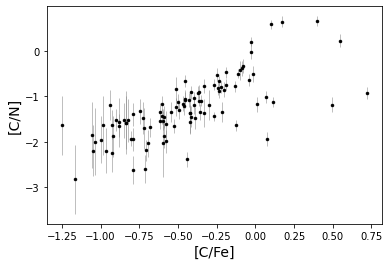

In [326]:
cfe = uves_nfe.c.values - solar.abund.get_element('C')
nfe = uves_nfe.n_nh.values - solar.abund.get_element('N')

plt.scatter(cfe[f_nfe_err], cfe[f_nfe_err] - nfe[f_nfe_err], s=5, color='k', zorder=9)
plt.errorbar(cfe[f_nfe_err], cfe[f_nfe_err] - nfe[f_nfe_err], yerr=uves_nfe.ec_sme.values[f_nfe_err], fmt='.', color='grey', alpha=0.5, lw=1)

plt.xlabel('[C/Fe]', size=14)
plt.ylabel('[C/N]', size=14)
plt.show()

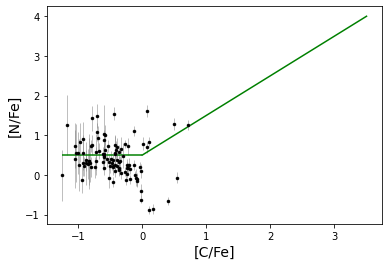

In [327]:
cfe = uves_nfe.c.values - solar.abund.get_element('C')
nfe = uves_nfe.n_nh.values - solar.abund.get_element('N')

plt.scatter(cfe[f_nfe_err], nfe[f_nfe_err] - 0.4, s=5, color='k', zorder=9)
plt.errorbar(cfe[f_nfe_err], nfe[f_nfe_err] - 0.4, yerr=uves_nfe.ec_sme.values[f_nfe_err], fmt='.', color='grey', alpha=0.5, lw=1)

plt.hlines(0.5, -1.25, 0.0, color='g')
x = np.linspace(0.0, 3.5)
plt.plot(x, x+0.5, color='g')

plt.xlabel('[C/Fe]', size=14)
plt.ylabel('[N/Fe]', size=14)
plt.show()

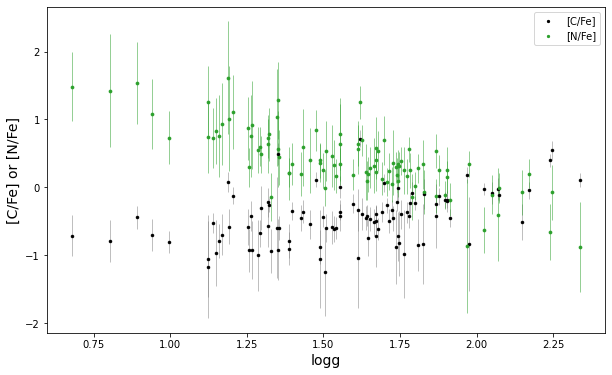

In [328]:
plt.figure(figsize=(10,6))

plt.scatter(uves_nfe.logg.values[f_nfe_err], cfe[f_nfe_err], s=5, color='k', zorder=9, label='[C/Fe]')
plt.errorbar(uves_nfe.logg.values[f_nfe_err], cfe[f_nfe_err], yerr=uves_nfe.ec_sme.values[f_nfe_err], fmt='.', color='grey', alpha=0.5, lw=1)
# plt.errorbar(uves_nfe.logg.values[~f_nfe_err], nfe[f_nfe_err], fmt='.', yerr=0.2 * np.ones_like(uves_nfe.en.values[is_limit]), ms=0.1, uplims=is_limit[is_limit], color='k', alpha=0.2)

plt.scatter(uves_nfe.logg.values[f_nfe_err], uves_nfe.n_nh.values[f_nfe_err] - 0.4 - solar.abund.get_element('N'), s=5, color='C2', zorder=9, label='[N/Fe]')
plt.errorbar(uves_nfe.logg.values[f_nfe_err], uves_nfe.n_nh.values[f_nfe_err] - 0.4 - solar.abund.get_element('N'), yerr=uves_nfe.en_nh_sme.values[f_nfe_err], fmt='.', color='C2', alpha=0.5, lw=1)
# plt.errorbar(uves_nfe.logg.values[~f_nfe_err], uves_nfe.n.values[~f_nfe_err] - solar.abund.get_element('N'), fmt='.', yerr=0.2 * np.ones_like(uves_nfe.en_sme.values[~f_nfe_err]), ms=0.1, uplims=is_limit[~f_nfe_err], color='k', alpha=0.2)

plt.xlabel('logg', size=14)
plt.ylabel('[C/Fe] or [N/Fe]', size=14)

plt.legend()
plt.show()

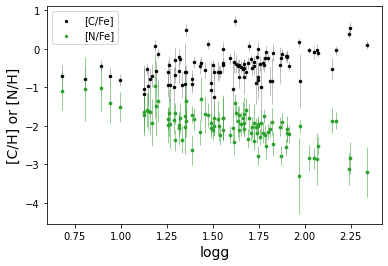

In [329]:
plt.scatter(uves_nfe.logg.values[f_nfe_err], cfe[f_nfe_err], s=5, color='k', zorder=9, label='[C/Fe]')
plt.errorbar(uves_nfe.logg.values[f_nfe_err], cfe[f_nfe_err], yerr=uves_nfe.ec_sme.values[f_nfe_err], fmt='.', color='grey', alpha=0.5, lw=1)
# plt.errorbar(uves_nfe.logg.values[is_limit], abund_limit[is_limit], fmt='.', yerr=0.2 * np.ones_like(uves_nfe.en.values[is_limit]), ms=0.1, uplims=is_limit[is_limit], color='k', alpha=0.2)

plt.scatter(uves_nfe.logg.values[f_nfe_err], uves_nfe.n_nh.values[f_nfe_err] + uves_nfe.monh.values[f_nfe_err] - solar.abund.get_element('N'), s=5, color='C2', zorder=9, label='[N/Fe]')
plt.errorbar(uves_nfe.logg.values[f_nfe_err], uves_nfe.n_nh.values[f_nfe_err] + uves_nfe.monh.values[f_nfe_err] - solar.abund.get_element('N'), yerr=uves_nfe.en_nh_sme.values[f_nfe_err], fmt='.', color='C2', alpha=0.5, lw=1)
plt.xlabel('logg', size=14)
plt.ylabel('[C/H] or [N/H]', size=14)

plt.legend()
plt.show()

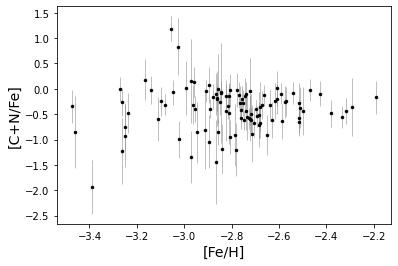

In [330]:
plt.scatter(uves_nfe.monh.values[f_nfe_err], cfe[f_nfe_err] * (uves_nfe.n_nh.values[f_nfe_err] - solar.abund.get_element('N')), s=5, color='k', zorder=9)
plt.errorbar(uves_nfe.monh.values[f_nfe_err], cfe[f_nfe_err] * (uves_nfe.n_nh.values[f_nfe_err] - solar.abund.get_element('N')), yerr=uves_nfe.en_nh_sme.values[f_nfe_err], fmt='.', color='grey', alpha=0.5, lw=1)
plt.xlabel('[Fe/H]', size=14)
plt.ylabel('[C+N/Fe]', size=14)
plt.show()

In [85]:
uves_nfe.sort_values(by=['c'], ascending=False).spec_id

94     6425379106130933376_3573700_088
83     6167441439259305088_3573234_046
151    6859555838257273600_3573691_115
150    6859555838257273600_3573691_106
106    6523938984849548032_3573742_119
                    ...               
110    6631364397619544448_3572790_006
41     3608416056475856512_3708499_157
127    6705676437173390848_3576283_076
133    6728409939582968192_3572831_014
59     4752197836317724160_3704064_123
Name: spec_id, Length: 160, dtype: object

In [349]:
uves_nfe.sort_values(by='n_nh', ascending=True)[['n_nh', 'spec_id']]

,n_nh,spec_id
94,4.019934,6425379106130933376_3573700_088
68,4.165231,5454289027730222848_3708466_149
9,4.259916,2569615268897126016_3708424_127
67,4.347718,5050991770433282688_3704139_126
62,4.365032,4854289415101796608_3708430_135
...,...,...
86,9.654957,6223323778439145216_3572846_011
126,9.715563,6704867982593521536_3573202_048
153,9.768747,6863375296834450304_3576316_083
58,9.843532,4450279330676186368_3576301_057


In [35]:
#Upper limits Nitrogen

In [383]:
sme = SME_Structure.load('sme_save/UVES_nfe_nh_6863375296834450304_3576316_083.sme')

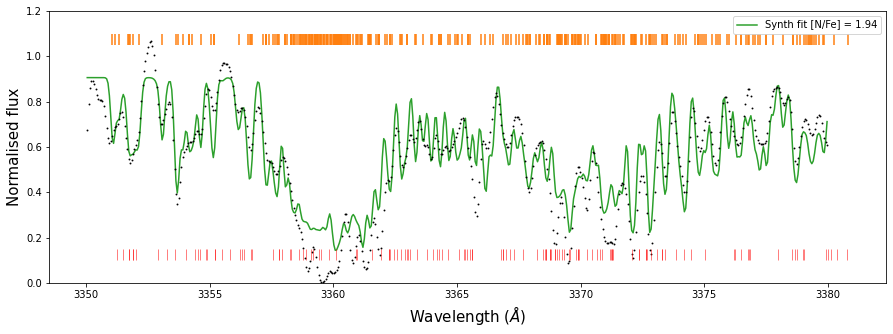

In [384]:
plt.figure(figsize=(15,5))

plt.scatter(sme.wave.data[sme.spec.data != 0.0], sme.spec.data[sme.spec.data != 0.0], s=0.8, color='k', alpha=0.99)
# plt.step(sme.wave.data[sme.spec.data != 0.0], convolution.convolve(sme.spec.data[sme.spec.data != 0.0], gaussian_kernel), lw=0.8, color='r', alpha=0.99)
plt.plot(sme.wave.data, sme.synth.data, lw=1.5, color='C2', alpha=1.0, label='Synth fit [N/Fe] = %2.2f' %(sme.abund.get_element('N')-sme.monh-solar.abund.get_element('N')), zorder=0)

# plt.plot(n_m5.wave.data, n_m5.synth.data, lw=1.5, color='k', alpha=0.3, label='A(N) = 2.8')
# plt.plot(n_m4.wave.data, n_m4.synth.data, lw=1.5, color='k', alpha=0.3, label='A(N) = 3.8')
# plt.plot(n_m3.wave.data, n_m3.synth.data, lw=1.5, color='k', alpha=0.3, label='A(N) = 4.8')
# plt.plot(n_m2.wave.data, n_m2.synth.data, lw=1.5, color='k', alpha=0.3, label='A(N) = 5.8')
# plt.plot(n_m1.wave.data, n_m1.synth.data, lw=1.5, color='k', alpha=0.3, label='A(N) = 6.8')
# plt.plot(n_p0.wave.data, n_p0.synth.data, lw=1.5, color='k', alpha=0.3, label='A(N) = 7.8 (Solar)')
# plt.plot(n_p1.wave.data, n_p1.synth.data, lw=1.5, color='k', alpha=0.3, label='A(N) = 8.8')
# plt.plot(n_p2.wave.data, n_p2.synth.data, lw=1.5, color='k', alpha=0.3, label='A(N) = 9.8')


plt.scatter(sme.wave.data[sme.mask.data == 2], sme.mask.data[sme.mask.data == 2]-1, color='grey', alpha=0.5)
# plt.scatter(sme.wave.data, sme.mask.data, color='C4', alpha=0.1)
ll = pd.DataFrame(sme.linelist)
for wline, species, depth in ll[['wlcent', 'species', 'depth']].values:#linelist_short_all[['wlcent', 'species', 'depth']]:
    # if 'H 1' in species:
    #     continue
    if (species == 'Fe 1') | (species == 'Fe 2'):
        plt.vlines(wline, 0.1, 0.15, color='r', lw=0.5)
        continue
    if (species == 'CH 1'):
        plt.vlines(wline, 0.1, 0.15, color='b')
        continue
    # if species not in elems_to_include:
    #     continue
    if species in elems_to_include:
        plt.vlines(wline, 1.05, 1.10, color='C1')
        continue
#     # if (depth > 0.85) | (depth < 0.15):
#     #     continue
    # plt.vlines(wline, 0.2, 0.25, color='C4')
    # plt.annotate(text='%s' %species, xy=(wline, 0.05), rotation=90)

# plt.xlim(3855, 3885)
# plt.xlim(3880, 3884)
# plt.xlim(3355, 3380)
# plt.xlim(3350, 3380)
plt.ylim(0.0, 1.2)

plt.legend()
plt.xlabel(r'Wavelength ($\AA$)', size=15)
plt.ylabel(r'Normalised flux', size=15)
# plt.savefig('plots/Nitrogen.pdf')
plt.show()

In [380]:
sme.fitresults.values,sme.fitresults.uncertainties

(array([9.76874675]), array([0.6073952]))

In [233]:
spec_id = '6859555838257273600_3573691_115'
sme = SME_Structure.load('sme_save/nfe_%s.sme' %spec_id)

[2024-04-19 11:48:57,906] [INFO] [sme:load:839]: Loading SME file sme_save/nfe_6859555838257273600_3573691_115.sme


INFO - Loading SME file sme_save/nfe_6859555838257273600_3573691_115.sme


In [234]:
elems = sme.abund.pattern.keys()

for elem in elems:
    if (elem == 'H') or (elem == 'He'):
        continue
    # if (elem == 'C') or (elem == 'N'):
    #     continue
    sme.abund.update_pattern({elem:0.0})

In [235]:
sme = synthesize_spectrum(sme)

[2024-04-19 11:48:58,549] [INFO] [synthesize:__init__:48]: Don't forget to cite your sources. Use sme.citation()


INFO - Don't forget to cite your sources. Use sme.citation()


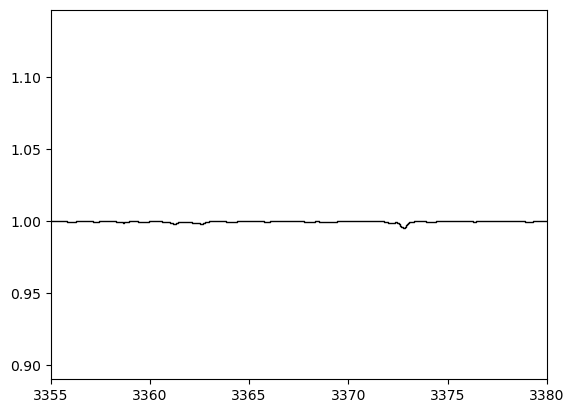

In [236]:
plt.step(sme.wave.data, sme.synth.data, lw=1, color='k')
plt.xlim(3855, 3885)
plt.xlim(3355, 3380)
plt.show()

In [237]:
np.mean(sme.spec.data[f_nh_wl]), np.std(sme.spec.data[f_cn_wl])

(0.5693440338656278, 0.044490831168623984)

In [106]:
sme.spec.data[f_nh_wl]

array([0.87426998, 0.93395017, 0.93826008, 0.91464276, 0.87807556,
       0.89197054, 0.87060079, 0.93669405, 0.57742056, 0.380498  ,
       0.80344702, 0.89123355, 0.8759266 , 0.90761004, 0.91511095,
       0.78134873, 1.02040752, 0.74068286, 0.91892574, 0.83058987,
       0.91013378, 0.81456068, 0.90942419, 0.74593334, 0.82179833,
       0.921729  , 0.77125879, 0.76866801, 0.76628651, 0.71403017,
       0.42154185, 0.64695427, 0.86223169, 0.88748663, 0.84331127,
       0.77715861, 0.83504591, 0.66688981, 0.78213975, 0.74728879,
       0.61618071, 0.65495439, 0.7487109 , 0.90248313, 0.85162956,
       0.8023593 , 0.93105655, 0.71835939, 0.8760673 , 0.88296817,
       0.8675818 , 0.90025685, 0.8149942 , 0.70413807, 0.75333442,
       0.55262469, 0.31315471, 0.18717376, 0.07028688, 0.41740825,
       0.56517402, 0.77478313, 0.64211335, 0.35678341, 0.49072966,
       0.80896257, 0.86335895, 0.76015608, 0.76956309, 0.67995822,
       0.41492705, 0.66082551])

In [364]:
f_nh_wl = (sme.wave.data > 3358.00) & (sme.wave.data < 3362.00)
f_cn_wl = (sme.wave.data > 3880.00) & (sme.wave.data < 3885.00)

f_nh_close = (sme.wave.data > 3359.00) & (sme.wave.data < 3361.00)
f_cn_close = (sme.wave.data > 3883.00) & (sme.wave.data < 3883.50)

In [365]:
spec_id

'6881847646233384704_3573240_054'

0.9449549308593979 0.15853977801973063 0.8414602219802694
0.9396331295719853 0.15853977801973063 0.8414602219802694
0.9079071186363886 0.15853977801973063 0.8414602219802694
0.7611399456733018 0.15853977801973063 0.8414602219802694


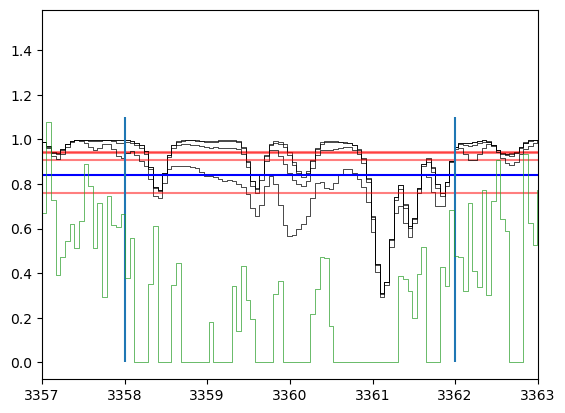

CPU times: user 22.2 s, sys: 200 ms, total: 22.4 s
Wall time: 22.2 s


In [380]:
%%time

species = 'N'
limit = 0.0
start, stop, step = -2.0, 2.0, 0.2

for delta_abund in np.linspace(start, stop, int((stop - start) / step + 1)):
    
    synth = SME_Structure.load('sme_save/nfe_%s.sme' %spec_id)
    synth.linelist = linelist_short_all[(linelist_short_all.wlcent > wmin_blue_1) & (linelist_short_all.wlcent < wmax_blue_1)]
    
    synth.abund.update_pattern({'%s' %species: solar.abund.get_element('%s' %species) + delta_abund})
    synth.abund.update_pattern({'Fe': 0.0})
    synth = synthesize_spectrum(synth)
    synth_data = synth.synth.data
    
    plt.step(synth.wave.data, synth_data, lw=0.5, color='k')
    
    mean_synth_nh = np.mean(synth_data[f_nh_close])
    std_spec_nh = np.std(synth.spec.data[f_nh_close])
    
    print(mean_synth_nh, std_spec_nh, 1. - std_spec_nh)
    
    plt.hlines(mean_synth_nh, 3357, 3363, color='r', alpha=0.5)
    
    #If mean synth flux is more (bigger depth) that std: you are in outside limit regime
    #linspace in the starst is fliped to ascend in abundance space
    if mean_synth_nh < (1. - std_spec_nh):
        limit = solar.abund.get_element('%s' %species) + delta_abund - step/2.
        break
    else:
        continue

plt.hlines(1-std_spec_nh, 3357, 3363, color='b')
plt.vlines(3358, 0, 1.1)
plt.vlines(3362, 0, 1.1)
plt.step(sme.wave.data, sme.spec.data, lw=0.5, color='C2')
# plt.xlim(3855, 3885)
plt.xlim(3357, 3363)
plt.show()

In [381]:
limit

7.855

5.83
0.964235229712378 0.057480197976389195 0.9425198020236109
6.030000000000001
0.9490459345487063 0.057480197976389195 0.9425198020236109
6.23
0.9259797918682386 0.057480197976389195 0.9425198020236109


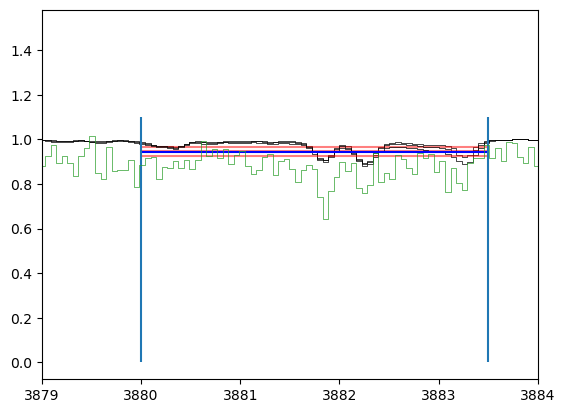

CPU times: user 15.2 s, sys: 116 ms, total: 15.3 s
Wall time: 15.1 s


In [382]:
%%time

species = 'N'
limit = 0.0
start, stop, step = -2.0, 2.0, 0.2

for delta_abund in np.linspace(start, stop, int((stop - start) / step + 1)):
    
    synth = SME_Structure.load('sme_save/nfe_%s.sme' %spec_id)
    synth.linelist = linelist_short_all[(linelist_short_all.wlcent > wmin_blue_2) & (linelist_short_all.wlcent < wmax_blue_2)]
    
    synth.abund.update_pattern({'%s' %species: solar.abund.get_element('%s' %species) + delta_abund - synth.monh})
    print(synth.abund.get_element('N'))
    synth.abund.update_pattern({'Fe': 0.0})
    synth = synthesize_spectrum(synth)
    synth_data = synth.synth.data
    
    plt.step(synth.wave.data, synth_data, lw=0.5, color='k')
    
    mean_synth_cn = np.mean(synth_data[f_cn_close])
    std_spec_cn = np.std(synth.spec.data[f_cn_close])
    
    print(mean_synth_cn, std_spec_cn, 1. - std_spec_cn)
    
    plt.hlines(mean_synth_cn, 3880, 3883.5, color='r', alpha=0.5)
    
    #If mean synth flux is more (bigger depth) that std: you are in outside limit regime
    #linspace in the starst is fliped to ascend in abundance space
    if mean_synth_cn < (1. - std_spec_cn):
        limit = solar.abund.get_element('%s' %species) + delta_abund - step/2.
        break
    else:
        continue

plt.hlines(1-std_spec_cn, 3880, 3883.5, color='b')
plt.vlines(3880, 0, 1.1)
plt.vlines(3883.5, 0, 1.1)
plt.step(sme.wave.data, sme.spec.data, lw=0.5, color='C2')
# plt.xlim(3855, 3885)
plt.xlim(3879, 3884)
plt.show()

In [384]:
limit

6.130000000000001

In [374]:
solar.abund.get_element('N')

7.83

In [143]:
# plt.scatter(cfe1.index, cfe1.cfe - solar.abund.get_element('C'), s=5, color='grey', alpha=0.4)
# plt.scatter(cfe2.index, cfe2.cfe - solar.abund.get_element('C'), s=5, color='grey', alpha=0.4)
# plt.scatter(cfe3.index, cfe3.cfe - solar.abund.get_element('C'), s=5, color='grey', alpha=0.4)
# plt.scatter(cfe4.index, cfe4.cfe - solar.abund.get_element('C'), s=5, color='grey', alpha=0.4)
# plt.scatter(cfe5.index, cfe5.cfe - solar.abund.get_element('C'), s=5, color='grey', alpha=0.4)
# plt.scatter(cfe6.index, cfe6.cfe - solar.abund.get_element('C'), s=5, color='grey', alpha=0.4)
# plt.scatter(cfe7.index, cfe7.cfe - solar.abund.get_element('C'), s=5, color='grey', alpha=0.4)
# plt.scatter(cfe8.index, cfe8.cfe - solar.abund.get_element('C'), s=5, color='grey', alpha=0.4)
# plt.scatter(cfe9.index, cfe9.cfe - solar.abund.get_element('C'), s=5, color='grey', alpha=0.4)
# plt.scatter(cfe10.index, cfe10.cfe - solar.abund.get_element('C'), s=5, color='grey', alpha=0.4)

# plt.scatter(nfe0.index, nfe0.nfe.values, s=5, color='k')
# # plt.errorbar(vmac1.teff_xgboost, vmac, fmt='k.', yerr=evmac, ms=0.5)
# # plt.errorbar(vmac1.index[evmac < 2.], vmac[evmac < 2.], fmt='k.', yerr=vmac_rms[evmac < 2.], ms=0)
# # plt.ylim(-1, 10)
# # plt.ylim(-0.5,35)
# plt.xlabel('Star number', size=14)
# plt.ylabel('N/Fe', size=14)
# plt.show()

In [29]:
# jina['feh'] = jina.Fe.values - solar.abund.get_element('Fe')
# jina['cfe'] = (jina.C.values - solar.abund.get_element('C')) - (jina.Fe.values - solar.abund.get_element('Fe'))

In [30]:
# plt.figure(figsize=(10,5))

# plt.subplot(1,2,1)

# plt.scatter(uves_cfe0.monh.values, uves_cfe0.c.values - solar.abund.get_element('C'), s=10, color='k', zorder=9)
# plt.errorbar(uves_cfe0.monh.values, uves_cfe0.c.values - solar.abund.get_element('C'), xerr=uves_cfe0.emonh.values, yerr=uves_cfe0.ec.values, fmt='k.', color='k', alpha=0.25)
# plt.scatter(jina.feh.values, jina.cfe.values, s=5, color='grey', alpha=0.25)

# plt.hlines(0.7, -4, -2, ls='--', color='C2')
# plt.hlines(1.0, -4, -2, ls=':', color='C2')

# plt.xlabel('[M/H]', size=14)
# plt.ylabel('[C/Fe]', size=14)
# plt.xlim(-4.0, -2.0)
# plt.ylim(-3.0, 2.5)

# plt.subplot(1,2,2)

# plt.scatter(uves_cfe0.monh.values, uves_cfe0.c.values + uves_cfe0.monh.values, s=10, color='k', zorder=9, label='_nolegend_')
# plt.errorbar(uves_cfe0.monh.values, uves_cfe0.c.values + uves_cfe0.monh.values, xerr=uves_cfe0.emonh.values, 
#              yerr=(uves_cfe0.ec.values**2. + uves_cfe0.emonh.values**2.)**0.5, fmt='k.', color='k', alpha=0.25, label='_nolegend_')
# plt.scatter(jina.feh.values, jina.C.values, s=5, color='grey', alpha=0.25, label='_nolegend_')

# x = np.linspace(-4, -2)
# plt.plot(x, solar.abund.get_element('C') + x + 0.7, ls='--', color='C2', label='[C/Fe] = 0.7')
# plt.plot(x, solar.abund.get_element('C') + x + 1.0, ls=':', color='C2', label='[C/Fe] = 1.0')

# plt.legend(loc='upper left', fontsize=12)

# plt.xlabel('[M/H]', size=14)
# plt.ylabel('A(C)', size=14)
# plt.xlim(-4.0, -2.0)
# plt.ylim(3, 8)

# plt.tight_layout()
# plt.savefig('plots/UVES_carbon.pdf', dpi=300)
# plt.show()

In [128]:
# print(uves_nfe0.spec_id.values[(uves_nfe0.c.values > 9.0)], 
# uves_nfe0.c.values[(uves_nfe0.c.values > 9.0)])

In [27]:
#Read complete file

In [127]:
# uves.sort_values(by='c', ascending=False).spec_id

In [153]:
spec_id = '2706817140174260224_3576298_070'
sme = SME_Structure.load('sme_save/nfe_%s.sme' %spec_id)
# sme = SME_Structure.load('sme_save/nfe_3474451177494568320_3576292_064.sme')

[2024-04-16 18:48:46,125] [INFO] [sme:load:839]: Loading SME file sme_save/nfe_2706817140174260224_3576298_070.sme


INFO - Loading SME file sme_save/nfe_2706817140174260224_3576298_070.sme


In [154]:
sme.fitresults.uncertainties

array([0.40178804])

In [298]:
# util.start_logging('logs/elems_limits.dat', level='WARNING')

In [299]:
sme.linelist = linelist_short_all[(linelist_short_all.wlcent > wmin_blue_1) & (linelist_short_all.wlcent < wmax_blue_2)]
sme = synthesize_spectrum(sme);

[2024-04-15 16:46:57,856] [INFO] [synthesize:__init__:48]: Don't forget to cite your sources. Use sme.citation()


INFO - Don't forget to cite your sources. Use sme.citation()


In [300]:
# %%time
# n_m1 = SME_Structure.load('sme_save/nfe_%s.sme' %spec_id)
# n_m1.linelist = linelist_short_all[(linelist_short_all.wlcent > wmin_blue) & (linelist_short_all.wlcent < wmax_blue)]
# n_m1.abund.update_pattern({'N':6.8})
# n_m1 = synthesize_spectrum(n_m1)

# n_p0 = SME_Structure.load('sme_save/nfe_%s.sme' %spec_id)
# n_p0.linelist = linelist_short_all[(linelist_short_all.wlcent > wmin_blue) & (linelist_short_all.wlcent < wmax_blue)]
# n_p0.abund.update_pattern({'N':7.8})
# n_p0 = synthesize_spectrum(n_p0)

# n_p1 = SME_Structure.load('sme_save/nfe_%s.sme' %spec_id)
# n_p1.linelist = linelist_short_all[(linelist_short_all.wlcent > wmin_blue) & (linelist_short_all.wlcent < wmax_blue)]
# n_p1.abund.update_pattern({'N':8.8})
# n_p1 = synthesize_spectrum(n_p1)

# n_p2 = SME_Structure.load('sme_save/nfe_%s.sme' %spec_id)
# n_p2.linelist = linelist_short_all[(linelist_short_all.wlcent > wmin_blue) & (linelist_short_all.wlcent < wmax_blue)]
# n_p2.abund.update_pattern({'N':9.8})
# n_p2 = synthesize_spectrum(n_p2)

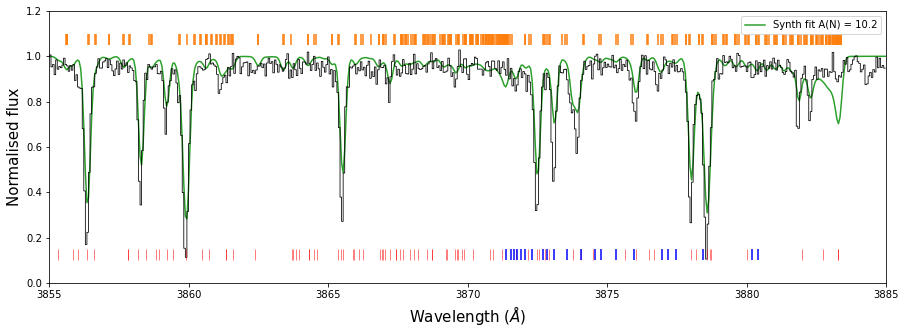

In [201]:
plt.figure(figsize=(15,5))

plt.step(sme.wave.data, sme.spec.data, lw=0.8, color='k', alpha=0.99)
plt.plot(sme.wave.data, sme.synth.data, lw=1.5, color='C2', alpha=1.0, label='Synth fit A(N) = %2.1f' %(sme.abund.get_element('N')-sme.monh), zorder=0)
# plt.plot(n_p0.wave.data, n_p0.synth.data, lw=1.5, color='k', alpha=0.3, label='A(N) = 7.8 (Solar)')
# plt.plot(n_p1.wave.data, n_p1.synth.data, lw=1.5, color='k', alpha=0.3, label='A(N) = 8.8')
# plt.plot(n_p2.wave.data, n_p2.synth.data, lw=1.5, color='k', alpha=0.3, label='A(N) = 9.8')

# plt.plot(sme.wave.data, no_n, lw=1.5, color='r', alpha=0.5)
# plt.plot(sme.wave.data, too_much_n, lw=1.5, color='b', alpha=0.5)

# sme.abund.update_pattern({'C':9.4})
# sme = synthesize_spectrum(sme);
# plt.plot(sme.wave.data, sme.synth.data, lw=1.5, color='r', alpha=0.5)

plt.scatter(sme.wave.data[sme.mask.data == 2], sme.mask.data[sme.mask.data == 2]-1, color='grey', alpha=0.5)
# plt.scatter(sme.wave.data, sme.mask.data, color='C4', alpha=0.1)
ll = pd.DataFrame(sme.linelist)
for wline, species, depth in ll[['wlcent', 'species', 'depth']].values:#linelist_short_all[['wlcent', 'species', 'depth']]:
    # if 'H 1' in species:
    #     continue
    if (species == 'Fe 1') | (species == 'Fe 2'):
        plt.vlines(wline, 0.1, 0.15, color='r', lw=0.5)
        continue
    if (species == 'CH 1'):
        plt.vlines(wline, 0.1, 0.15, color='b')
        continue
    # if species not in elems_to_include:
    #     continue
    if species in elems_to_include:
        plt.vlines(wline, 1.05, 1.10, color='C1')
        continue
#     # if (depth > 0.85) | (depth < 0.15):
#     #     continue
    # plt.vlines(wline, 0.2, 0.25, color='C4')
    # plt.annotate(text='%s' %species, xy=(wline, 0.05), rotation=90)

# plt.xlim(3785, 3885)
# plt.xlim(3878, 3885)
# plt.xlim(3840, 3850)
# plt.xlim(3850, 3860)
# plt.xlim(3790, 3805)
# plt.xlim(3855, 3863)
# plt.xlim(3800, 3820)
plt.xlim(3855, 3885)
# plt.xlim(3881, 3884)
# plt.xlim(3800, 3900)
# plt.xlim(3352, 3380)
plt.ylim(0.0, 1.2)

plt.legend()
plt.xlabel(r'Wavelength ($\AA$)', size=15)
plt.ylabel(r'Normalised flux', size=15)
# plt.savefig('plots/Nitrogen.pdf')
plt.show()

In [36]:
sme.abund.get_element('N') - sme.monh - solar.abund.get_element('N')

0.9063495493237159

In [154]:
uves.query("spec_id == '%s'" %spec_id).blue_file

124    ADP.2023-06-09T13:36:55.014.fits
Name: blue_file, dtype: object

In [134]:
sme.vmac

7.470386014866404

In [135]:
sme.abund.get_element('C') - sme.monh

9.38349882277035

In [136]:
sme.fitresults.values, sme.fitresults.uncertainties

(array([9.79657777]), array([0.27234898]))

In [137]:
sme.logg

1.5687772709031964

In [138]:
sme.fitresults.chisq

1.206201378636083e-05

In [139]:
sme.monh

-3.1031525735629115

In [140]:
sme.cscale

array([[1.]])

In [58]:
sme.vmac

7.470386014866404

In [388]:
uves.teff.values[0], uves.monh.values[0], uves.vmic.values[0], uves.vmac.values[0],

(4968.682877070253, -2.843529443332338, 2.266956727799531, 4.850054601013983)

In [30]:
# ll = pd.DataFrame(linelist_short_all)

In [31]:
# ll.query("species == 'CH 1'")
# np.unique(np.ravel(linelist_short_all[['species']]))

In [32]:
# plt.hist(ll.query("species == 'CH 1'").wlcent, bins=100)
# plt.show()

In [27]:
sme.linelist = linelist_short_all

In [28]:
# sme.abund.update_pattern({'C':7.8})
# sme.abund.update_pattern({'Ba':2.1})

In [29]:
%%time
sme = synthesize_spectrum(sme)

[2024-02-21 15:34:05,482] [INFO] [synthesize:__init__:48]: Don't forget to cite your sources. Use sme.citation()


INFO - Don't forget to cite your sources. Use sme.citation()
CPU times: user 5.66 s, sys: 12 ms, total: 5.68 s
Wall time: 5.67 s


In [30]:
elems_to_include

['C 1', 'C2 1', 'CH 1', 'CN 1']

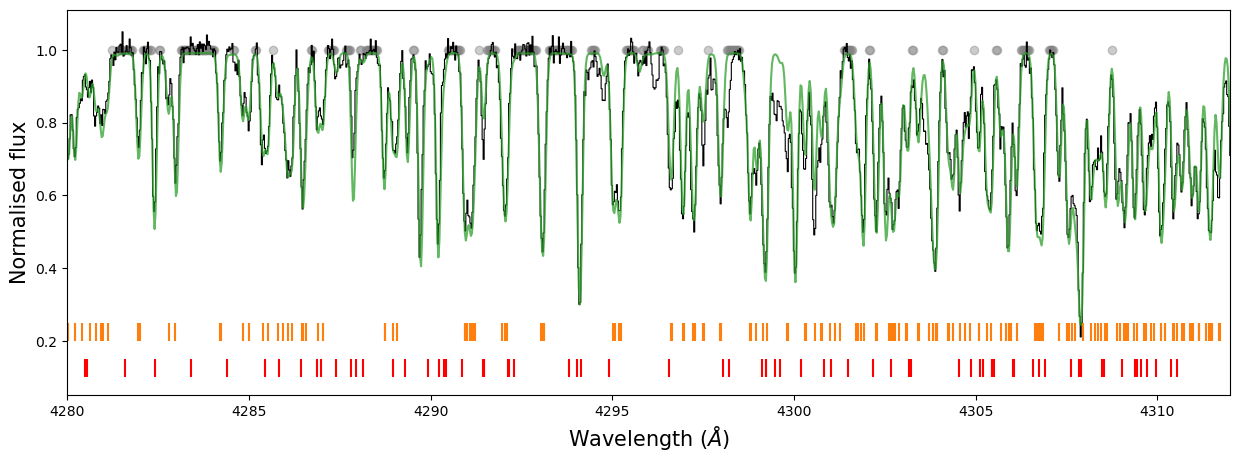

In [32]:
plt.figure(figsize=(15,5))

plt.step(sme.wave.data, sme.spec.data, lw=0.8, color='k')
plt.plot(sme.wave.data, sme.synth.data, lw=1.5, color='C2', alpha=0.75)

plt.scatter(sme.wave.data[sme.mask.data == 2], sme.mask.data[sme.mask.data == 2]-1, color='grey', alpha=0.4)
# plt.scatter(sme.wave.data, sme.mask.data, color='grey', alpha=0.4)

for wline, species, depth in linelist_short_all[['wlcent', 'species', 'depth']]:
    # if 'H 1' in species:
    #     continue
    if (species == 'Fe 1') | (species == 'Fe 2'):
        plt.vlines(wline, 0.1, 0.15, color='r')
    if (species == 'CN 1'):
        plt.vlines(wline, 0.05, 0.15, color='b')
    if species not in elems_to_include:
        continue
#     # if (depth > 0.85) | (depth < 0.15):
#     #     continue
    plt.vlines(wline, 0.2, 0.25, color='C1')
    # plt.annotate(text='%s' %species, xy=(wline, 0.05), rotation=90)

# plt.hlines(1.02, 4250, 4300)

# plt.ylim(0, 1.1)
# plt.xlim(5165.5, 5185) #Mg
# plt.xlim(4213, 4219) #Sr
# plt.xlim(4074, 4080) #Sr
# plt.xlim(4930, 4938) #Ba
# plt.xlim(4882, 4885) #Y

# plt.xlim(4250, 4350)
# plt.xlim(4280, 4327)

plt.xlim(4280, 4312)
# plt.xlim(3790, 3885)

plt.xlabel(r'Wavelength ($\AA$)', size=15)
plt.ylabel(r'Normalised flux', size=15)
# plt.xlim(6500, 6600)
plt.savefig('plots/CEMP2.pdf')
plt.show()

In [21]:
sme.cscale, sme.fitresults.uncertainties

(array([[0.97984875]]), array([0.6454197]))

In [72]:
#Carbon continuum regions

In [73]:
cont_blue = ispec.read_continuum_regions('continuum_model/continuum_regions_blue.txt')

In [76]:
# %%time

cont_mask_blue = np.zeros_like(sme.wave.data)

for mask_i, wl in enumerate(sme.wave.data/10.):
    for cont_low, cont_high in cont_blue:
        if (wl <= cont_low) | (wl >= cont_high):
            continue
        else:
            cont_mask_blue[mask_i] = 2
            break

In [77]:
np.savetxt('continuum_model/sme_cont_mask_blue_carbon', cont_mask_blue, fmt='%d')

In [58]:
# sme.monh

In [56]:
# plt.figure(figsize=(8,4))
# plt.step(sme.wave.data, (sme.spec.data - sme.synth.data) / sme.spec.data * 100, lw=0.5, color='k')
# plt.xlim(4290, 4315)
# plt.show()

In [128]:
np.std(sme.spec.data / sme.synth.data)

0.042932545956683235

In [77]:
np.unique(sme.linelist.species)

array(['CH 1', 'Ca 1', 'Ce 2', 'Co 1', 'Cr 1', 'Cr 2', 'Dy 2', 'Fe 1',
       'Fe 2', 'Gd 2', 'La 2', 'Mg 1', 'Mn 1', 'Mn 2', 'Na 1', 'Nd 2',
       'Ni 1', 'Os 1', 'Pr 2', 'Sc 2', 'Si 1', 'Sm 2', 'Sr 2', 'Ti 1',
       'Ti 2', 'V 1', 'V 2', 'Y 2', 'Zr 2'], dtype='<U4')

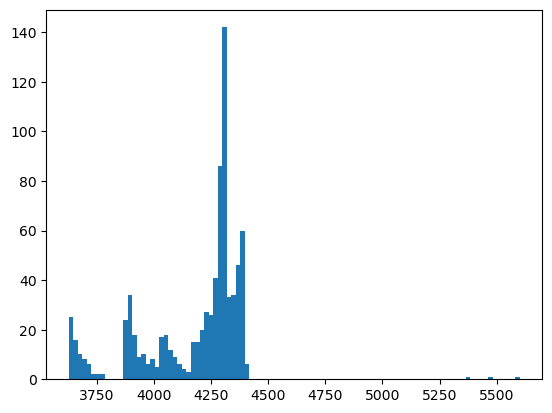

In [108]:
ll = pd.DataFrame(linelist_short_all)
plt.hist(ll.query("species == 'CH 1'").wlcent, bins=100)
plt.show()

In [21]:
# sme.nlte, INFO - Abund fe  	7.45971 +- 0.0029271

#INFO - Abund mg  	5.56803 +- 0.021141

In [24]:
# sme = SME_Structure.load('sme_save/atm_111.251N.002_3818459160048340352_038.sme')
sme = SME_Structure.load('sme_save/atm_111.251N.001_1166634514845213568_000.sme')

[2024-02-02 10:40:48,258] [INFO] [sme:load:839]: Loading SME file sme_save/atm_111.251N.001_1166634514845213568_000.sme


INFO - Loading SME file sme_save/atm_111.251N.001_1166634514845213568_000.sme


In [53]:
linelist_short_all.wlcent

array([4000.0662, 4000.0958, 4000.0994, ..., 6797.999 , 6798.2449,
       6798.317 ])

In [30]:
# sme = synthesize_spectrum(sme)

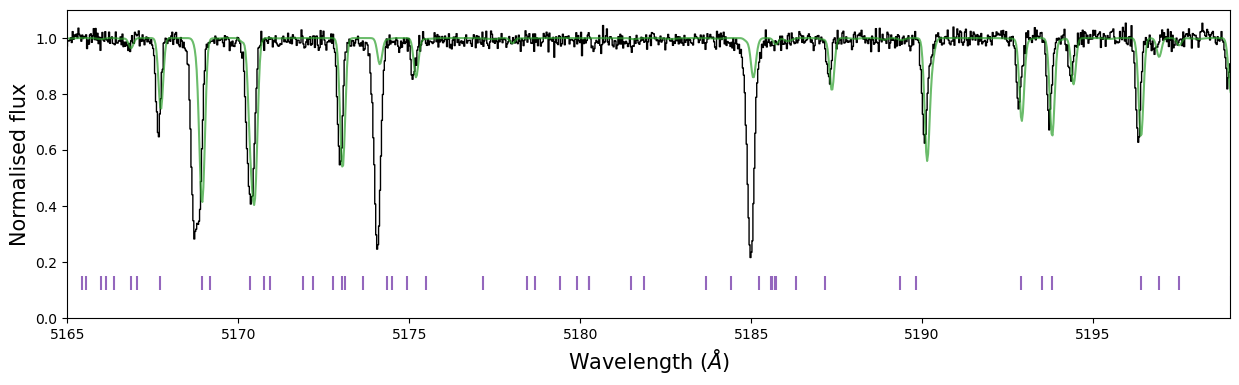

In [72]:
plt.figure(figsize=(15,4))
plt.step(sme.wave.data, sme.spec.data, color='k', lw=1)
plt.plot(sme.wave.data, sme.synth.data, color='C2', lw=1.5, alpha=0.7)

for wline, species, depth in linelist_short_all[['wlcent', 'species', 'depth']]:
    if 'H 1' in species:
        continue
    if species == 'Fe 1':
        plt.vlines(wline, 0.1, 0.15, color='C4')
    if species not in elems_to_include:  
        continue
#     # if (depth > 0.85) | (depth < 0.15):
#     #     continue
    plt.vlines(wline, 0.2, 0.25, color='C0')
    plt.annotate(text='%s' %species, xy=(wline-0.15, 0.05), rotation=90)
    # plt.annotate(text='%2.3f' %depth, xy=(wline-0.15, 0.5), rotation=90)
    
# plt.scatter(sme.wave.data, sme.mask.data)

plt.xlabel(r'Wavelength ($\AA$)', size=15)
plt.ylabel(r'Normalised flux', size=15)

# plt.xlim(4080, 4120)
# plt.xlim(4172, 4190)
# plt.xlim(4220, 4240)
# plt.xlim(4850, 4870)

# plt.xlim(4930, 4945) #Ba line
# plt.xlim(5850, 5856) #Ba line
# plt.xlim(6141, 6143) #Ba line
# plt.xlim(6494, 6498) #Ba line

# plt.xlim(6706, 6711)
# plt.xlim(5360, 5370)

plt.xlim(5165, 5199)
# plt.xlim(5885, 5900)
# plt.xlim(6550, 6570)
# plt.hlines(1, 4125, 4132)

plt.ylim(0.0, 1.1)
plt.show()

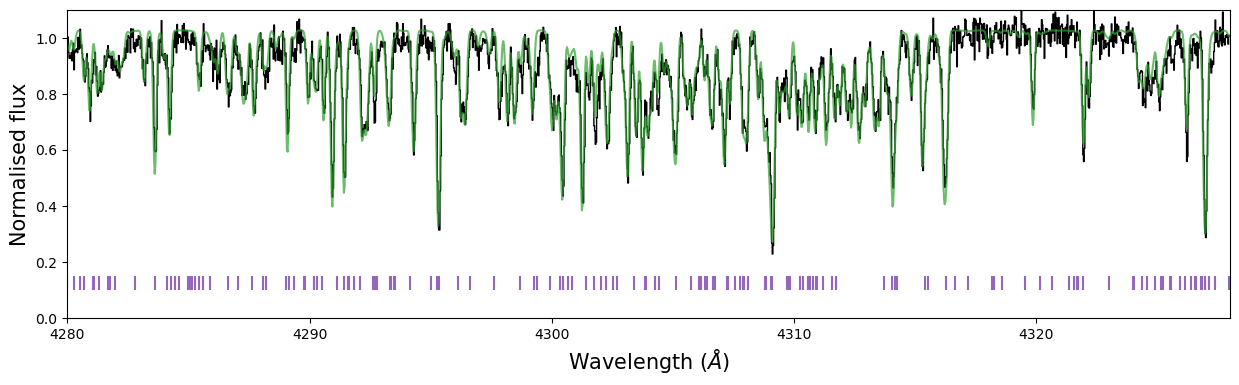

In [137]:
plt.figure(figsize=(15,4))
plt.step(sme.wave.data+1.25, sme.spec.data, color='k', lw=1)
plt.plot(sme.wave.data, sme.synth.data+0.04, color='C2', lw=1.5, alpha=0.7)

for wline, species, depth in linelist_short_all[['wlcent', 'species', 'depth']]:
    if 'H 1' in species:
        continue
    if species == 'Fe 1':
        plt.vlines(wline, 0.1, 0.15, color='C4')
    if species not in elems_to_include:  
        continue
#     # if (depth > 0.85) | (depth < 0.15):
#     #     continue
    plt.vlines(wline, 0.2, 0.25, color='C0')
    # plt.annotate(text='%s' %species, xy=(wline-0.15, 0.05), rotation=90)
    # plt.annotate(text='%2.3f' %depth, xy=(wline-0.15, 0.5), rotation=90)
    
# plt.scatter(sme.wave.data, sme.mask.data)

plt.xlabel(r'Wavelength ($\AA$)', size=15)
plt.ylabel(r'Normalised flux', size=15)

# plt.xlim(4080, 4120)
# plt.xlim(4172, 4190)
# plt.xlim(4220, 4240)
# plt.xlim(4850, 4870)

# plt.xlim(4930, 4945) #Ba line
# plt.xlim(5850, 5856) #Ba line
# plt.xlim(6141, 6143) #Ba line
# plt.xlim(6494, 6498) #Ba line

plt.xlim(4280, 4328)
# plt.xlim(5360, 5370)

# plt.xlim(5165, 5199)
# plt.xlim(5885, 5900)
# plt.xlim(6550, 6570)
# plt.hlines(1, 4125, 4132)

plt.ylim(0.0, 1.1)
plt.show()

In [191]:
ll = pd.DataFrame(linelist_short_all)

In [192]:
ll.head(2)

,species,wlcent,excit,vmic,gflog,gamrad,gamqst,gamvw,lande,depth,reference,atom_number,ionization
0,Mn 1,4001.183270,3.7716,1.0,-1.46,7.05,-6.22,-7.82,1.21,0.058,12 wl:K07 12 K07 37 gf:MFW 12 K07 12 K07...,1.0,1.0
1,Gd 2,4001.248953,0.5223,1.0,-0.78,0.00,0.00,0.00,2.26,0.074,15 wl:DLSC 15 DLSC 15 gf:DLSC 15 DLSC 15...,1.0,2.0


In [193]:
ll.query("species == 'Ba 2'")

,species,wlcent,excit,vmic,gflog,gamrad,gamqst,gamvw,lande,depth,reference,atom_number,ionization
2072,Ba 2,4130.644992,2.7218,1.0,0.680,0.0,0.0,0.000,1.07,0.672,25 wl:MW 25 MW 25 gf:MW 25 MW 25 MW 25 ...,1.0,2.0
2678,Ba 2,4166.000023,2.7218,1.0,-0.420,0.0,0.0,0.000,1.06,0.206,25 wl:MW 25 MW 25 gf:MW 25 MW 25 MW 25 ...,1.0,2.0
8793,Ba 2,4899.929035,2.7218,1.0,-0.080,0.0,0.0,0.000,1.16,0.300,25 wl:MW 25 MW 25 gf:MW 25 MW 25 MW 25 ...,1.0,2.0
8963,Ba 2,4934.074368,0.0000,1.0,-1.331,0.0,0.0,303.222,99.00,0.782,25 iso:WABM 25 MW 25 gf:MW 25 MW 25 MW ...,1.0,2.0
8964,Ba 2,4934.074368,0.0000,1.0,-3.125,0.0,0.0,303.222,99.00,0.171,25 iso:WABM 25 MW 25 gf:MW 25 MW 25 MW ...,1.0,2.0
8965,Ba 2,4934.074968,0.0000,1.0,-3.146,0.0,0.0,303.222,99.00,0.165,25 iso:WABM 25 MW 25 gf:MW 25 MW 25 MW ...,1.0,2.0
8966,Ba 2,4934.075068,0.0000,1.0,-1.100,0.0,0.0,303.222,99.00,0.813,25 iso:WABM 25 MW 25 gf:MW 25 MW 25 MW ...,1.0,2.0
8967,Ba 2,4934.075468,0.0000,1.0,-1.767,0.0,0.0,303.222,99.00,0.705,25 iso:WABM 25 MW 25 gf:MW 25 MW 25 MW ...,1.0,2.0
8968,Ba 2,4934.075767,0.0000,1.0,-1.255,0.0,0.0,303.222,99.00,0.793,25 iso:WABM 25 MW 25 gf:MW 25 MW 25 MW ...,1.0,2.0
8969,Ba 2,4934.077267,0.0000,1.0,-0.294,0.0,0.0,303.222,99.00,0.888,25 iso:WABM 25 MW 25 gf:MW 25 MW 25 MW ...,1.0,2.0


In [21]:
ll.index[110]

110